# 🏠 Intelligent House Price Prediction System

**Project Title:** Intelligent House Price Prediction System Using Machine Learning

**Group Members:**
- Muhammad Usman Rajput (450327)
- Muhammad Ramish Ali (537262)
- Malik Huzaifa Saeed (539701)

---

## Table of Contents
1. [Imports & Setup](#1-imports--setup)
2. [Data Loading](#2-data-loading)
3. [Data Preprocessing](#3-data-preprocessing)
4. [Exploratory Data Analysis](#4-exploratory-data-analysis)
5. [Feature Engineering](#5-feature-engineering)
6. [Model Training](#6-model-training)
7. [Model Evaluation](#7-model-evaluation)
8. [Save Model for Deployment](#8-save-model-for-deployment)
9. [Predictions & Submission](#9-predictions--submission)
10. [Conclusion](#10-conclusion)

## 1. Imports & Setup

In [2]:
# Core Libraries
import numpy as np
import pandas as pd
import warnings
import os
import pickle
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

# Model - Linear Regression
from sklearn.linear_model import LinearRegression

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Create directories
os.makedirs('visualizations', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Data Loading

In [3]:
# Load the datasets
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

print(f"📊 Training Data Shape: {train_df.shape}")
print(f"📊 Test Data Shape: {test_df.shape}")
print(f"\n🎯 Target Variable: SalePrice")

📊 Training Data Shape: (1460, 81)
📊 Test Data Shape: (1459, 80)

🎯 Target Variable: SalePrice


In [4]:
# Display first few rows
print("\n📋 First 5 rows of training data:")
train_df.head()


📋 First 5 rows of training data:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Basic info about the dataset
print("\n📋 Dataset Information:")
print("="*50)
print(f"Total Features: {train_df.shape[1] - 1}")
print(f"Total Samples: {train_df.shape[0]}")
print(f"\nNumerical Features: {train_df.select_dtypes(include=[np.number]).shape[1]}")
print(f"Categorical Features: {train_df.select_dtypes(include=['object']).shape[1]}")


📋 Dataset Information:
Total Features: 80
Total Samples: 1460

Numerical Features: 38
Categorical Features: 43


In [6]:
# Target variable statistics
print("\n🎯 Target Variable (SalePrice) Statistics:")
print("="*50)
print(train_df['SalePrice'].describe())


🎯 Target Variable (SalePrice) Statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


## 3. Data Preprocessing

### 3.1 Missing Values Analysis

In [7]:
# Check missing values in training data
missing_train = train_df.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
missing_percent = (missing_train / len(train_df)) * 100

print("\n🔍 Missing Values in Training Data:")
print("="*50)
missing_df = pd.DataFrame({
    'Missing Count': missing_train,
    'Missing %': missing_percent.round(2)
})
print(missing_df)


🔍 Missing Values in Training Data:
              Missing Count  Missing %
PoolQC                 1453      99.52
MiscFeature            1406      96.30
Alley                  1369      93.77
Fence                  1179      80.75
MasVnrType              872      59.73
FireplaceQu             690      47.26
LotFrontage             259      17.74
GarageType               81       5.55
GarageYrBlt              81       5.55
GarageFinish             81       5.55
GarageQual               81       5.55
GarageCond               81       5.55
BsmtExposure             38       2.60
BsmtFinType2             38       2.60
BsmtQual                 37       2.53
BsmtCond                 37       2.53
BsmtFinType1             37       2.53
MasVnrArea                8       0.55
Electrical                1       0.07


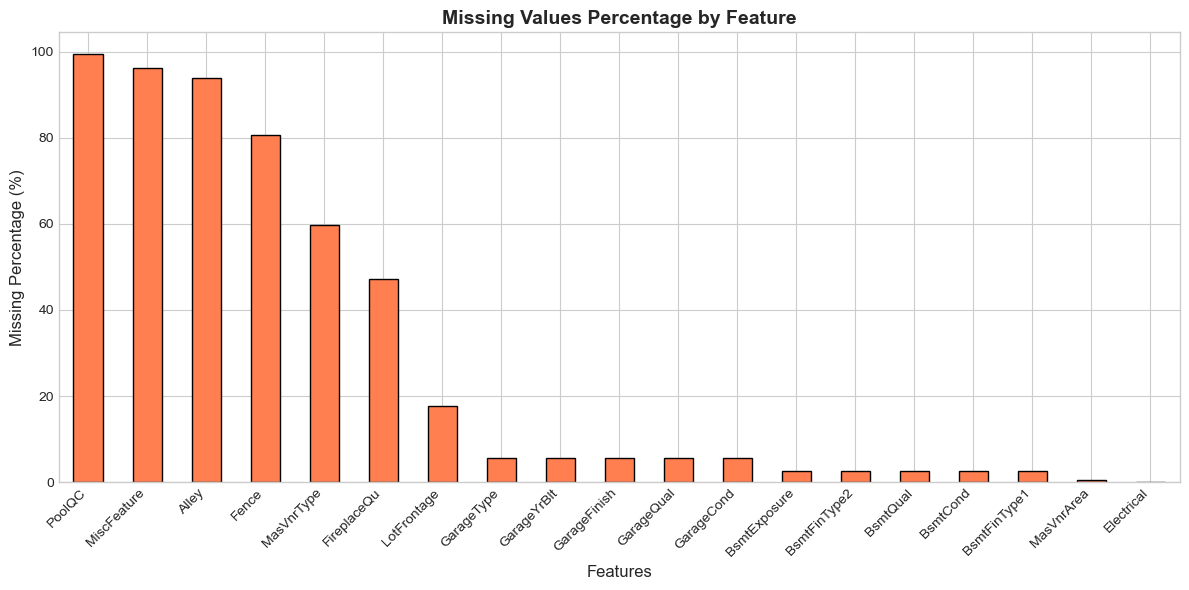

In [8]:
# Visualize missing values
plt.figure(figsize=(12, 6))
missing_df['Missing %'].plot(kind='bar', color='coral', edgecolor='black')
plt.title('Missing Values Percentage by Feature', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/missing_values.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Handle Missing Values

In [9]:
# Save target and IDs
y_train = train_df['SalePrice'].copy()
train_ids = train_df['Id'].copy()
test_ids = test_df['Id'].copy()

# Drop Id and SalePrice from training data
train_df = train_df.drop(['Id', 'SalePrice'], axis=1)
test_df = test_df.drop(['Id'], axis=1)

# Combine datasets for consistent preprocessing
ntrain = train_df.shape[0]
combined_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
print(f"Combined dataset shape: {combined_df.shape}")

Combined dataset shape: (2919, 79)


In [10]:
# Handle missing values based on feature type

# Features where NA means "None" (no feature exists)
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']

for col in none_cols:
    if col in combined_df.columns:
        combined_df[col] = combined_df[col].fillna('None')

# Numerical features with 0 for NA (no feature)
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
             'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

for col in zero_cols:
    if col in combined_df.columns:
        combined_df[col] = combined_df[col].fillna(0)

# Fill LotFrontage with median of neighborhood
combined_df['LotFrontage'] = combined_df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# Fill remaining missing values
# Numerical: fill with median
num_cols = combined_df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if combined_df[col].isnull().sum() > 0:
        combined_df[col] = combined_df[col].fillna(combined_df[col].median())

# Categorical: fill with mode
cat_cols = combined_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if combined_df[col].isnull().sum() > 0:
        combined_df[col] = combined_df[col].fillna(combined_df[col].mode()[0])

print(f"\n✅ Missing values after handling: {combined_df.isnull().sum().sum()}")


✅ Missing values after handling: 0


## 4. Exploratory Data Analysis

### 4.1 Target Variable Distribution

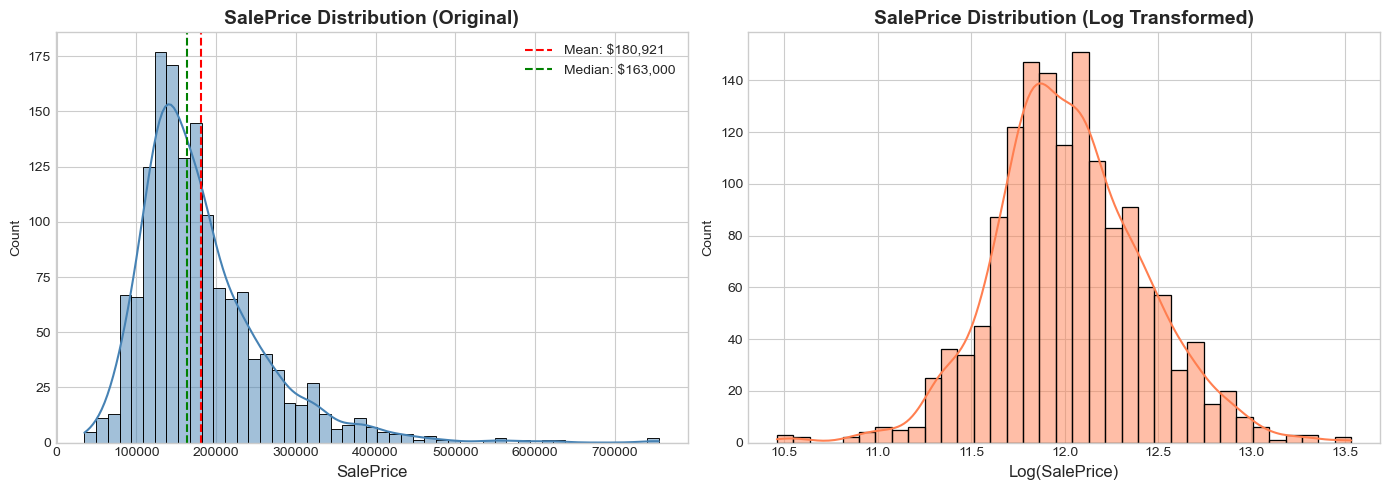


📊 Skewness (Original): 1.8829
📊 Skewness (Log-transformed): 0.1213


In [11]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
sns.histplot(y_train, kde=True, ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('SalePrice Distribution (Original)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('SalePrice', fontsize=12)
axes[0].axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: ${y_train.mean():,.0f}')
axes[0].axvline(y_train.median(), color='green', linestyle='--', label=f'Median: ${y_train.median():,.0f}')
axes[0].legend()

# Log-transformed distribution
y_train_log = np.log1p(y_train)
sns.histplot(y_train_log, kde=True, ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('SalePrice Distribution (Log Transformed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log(SalePrice)', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Skewness (Original): {y_train.skew():.4f}")
print(f"📊 Skewness (Log-transformed): {y_train_log.skew():.4f}")

### 4.2 Correlation Analysis

In [12]:
# Correlation with target variable
train_with_target = combined_df.iloc[:ntrain].copy()
train_with_target['SalePrice'] = y_train.values

# Get numerical columns correlation with SalePrice
numeric_df = train_with_target.select_dtypes(include=[np.number])
correlations = numeric_df.corr()['SalePrice'].sort_values(ascending=False)

print("\n🔗 Top 15 Features Correlated with SalePrice:")
print("="*50)
print(correlations.head(16))


🔗 Top 15 Features Correlated with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.347806
WoodDeckSF      0.324413
Name: SalePrice, dtype: float64


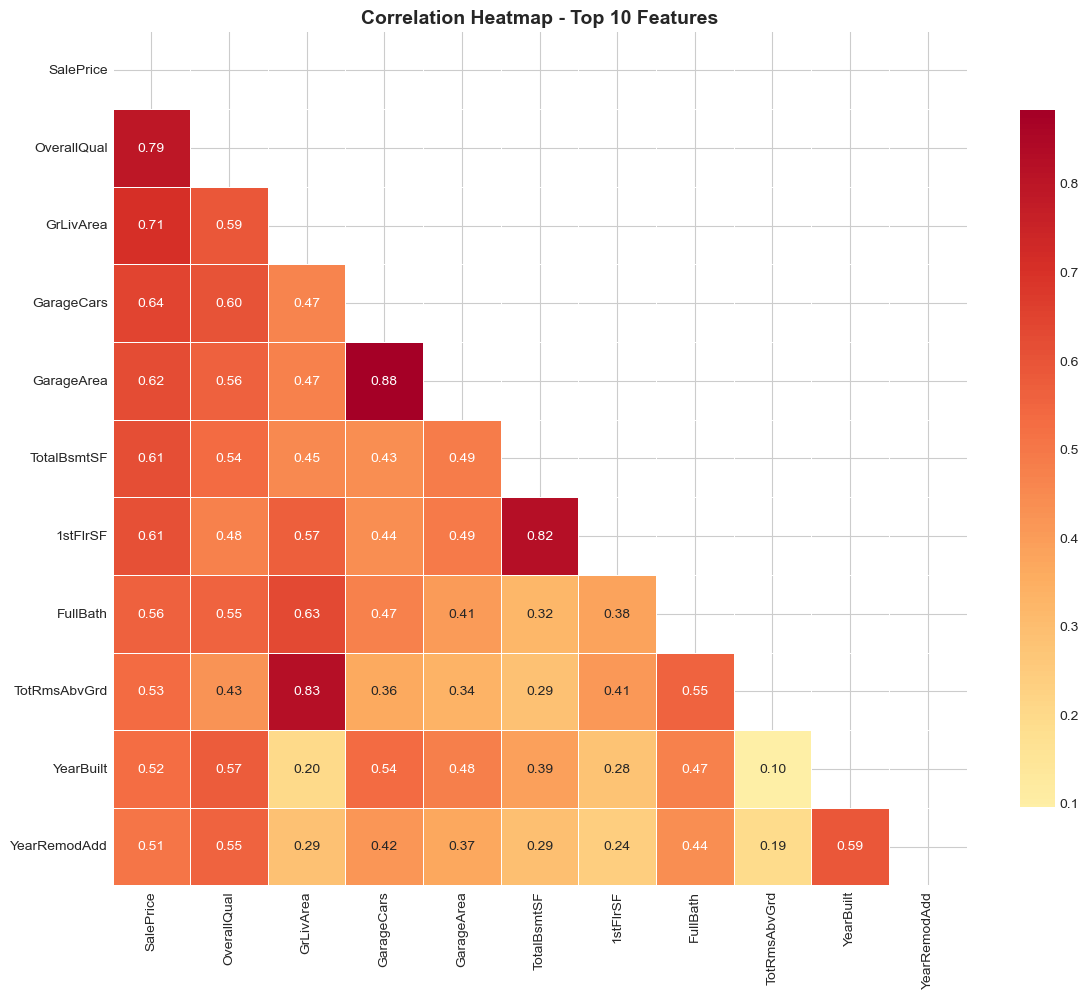

In [13]:
# Correlation heatmap for top features
top_features = correlations.head(11).index.tolist()
plt.figure(figsize=(12, 10))
corr_matrix = numeric_df[top_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            fmt='.2f', square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap - Top 10 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.3 Feature Distributions

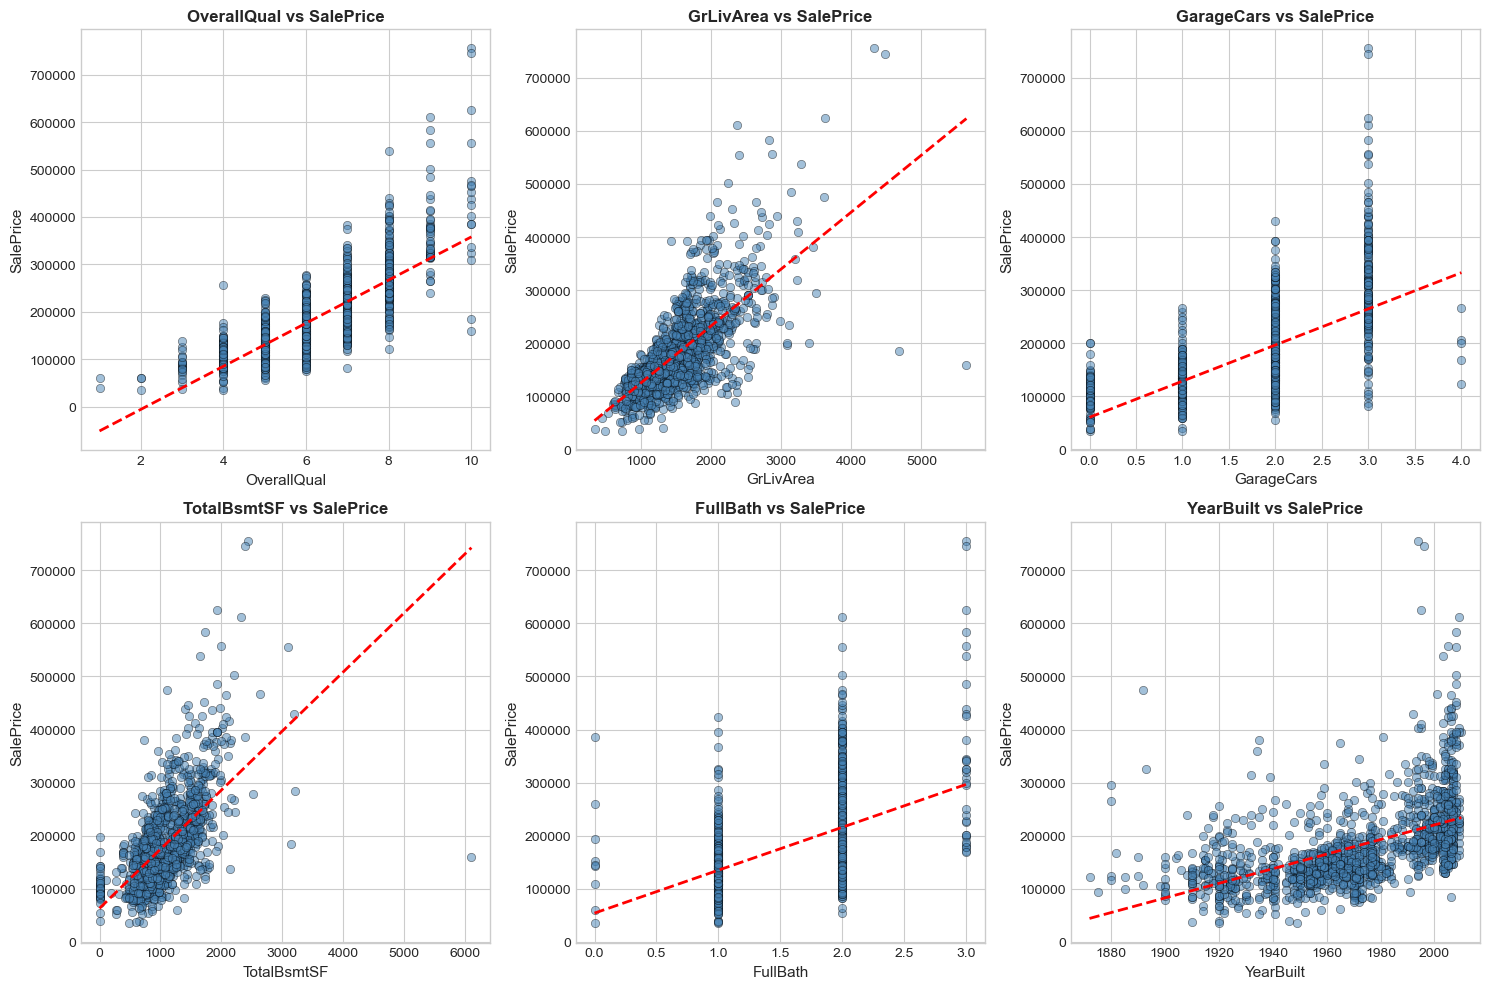

In [14]:
# Scatter plots for top correlated features
top_corr_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_corr_features):
    axes[i].scatter(train_with_target[feature], train_with_target['SalePrice'], 
                    alpha=0.5, c='steelblue', edgecolors='black', linewidth=0.5)
    axes[i].set_xlabel(feature, fontsize=11)
    axes[i].set_ylabel('SalePrice', fontsize=11)
    axes[i].set_title(f'{feature} vs SalePrice', fontsize=12, fontweight='bold')
    
    # Add trend line
    z = np.polyfit(train_with_target[feature], train_with_target['SalePrice'], 1)
    p = np.poly1d(z)
    axes[i].plot(train_with_target[feature].sort_values(), 
                 p(train_with_target[feature].sort_values()), 
                 color='red', linewidth=2, linestyle='--')

plt.tight_layout()
plt.savefig('visualizations/scatter_plots.png', dpi=150, bbox_inches='tight')
plt.show()

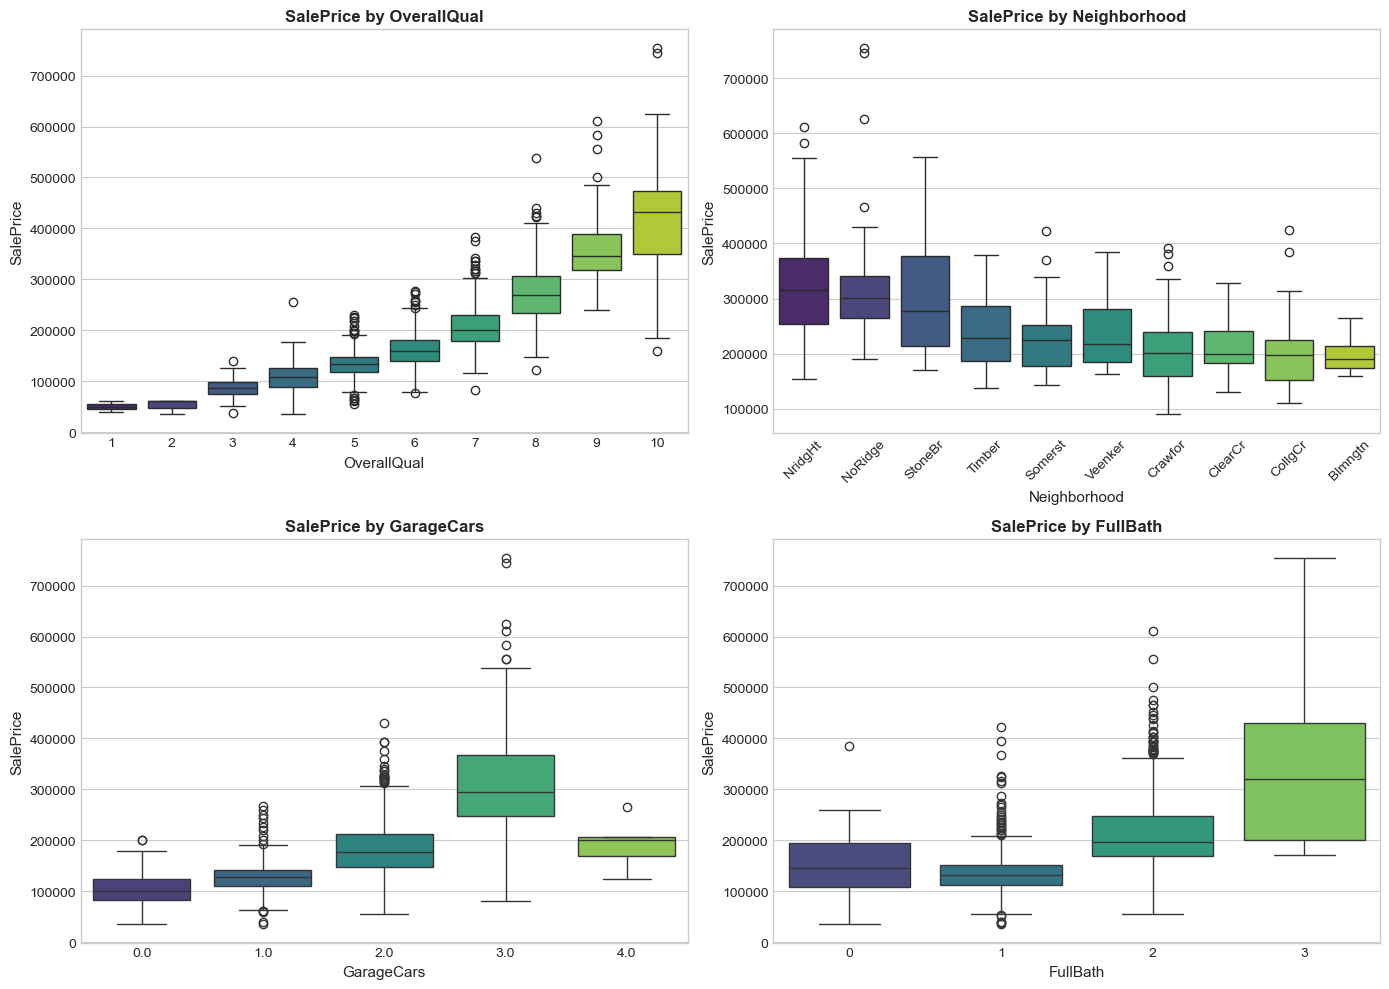

In [15]:
# Box plots for categorical features
cat_features = ['OverallQual', 'Neighborhood', 'GarageCars', 'FullBath']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(cat_features):
    if feature == 'Neighborhood':
        order = train_with_target.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False).head(10).index
        data = train_with_target[train_with_target['Neighborhood'].isin(order)]
        sns.boxplot(data=data, x=feature, y='SalePrice', ax=axes[i], palette='viridis', order=order)
        axes[i].tick_params(axis='x', rotation=45)
    else:
        sns.boxplot(data=train_with_target, x=feature, y='SalePrice', ax=axes[i], palette='viridis')
    axes[i].set_title(f'SalePrice by {feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=11)
    axes[i].set_ylabel('SalePrice', fontsize=11)

plt.tight_layout()
plt.savefig('visualizations/box_plots.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Feature Engineering

In [16]:
# Create new features
print("\n🔧 Creating new features...")

# Total Square Feet
combined_df['TotalSF'] = combined_df['TotalBsmtSF'] + combined_df['1stFlrSF'] + combined_df['2ndFlrSF']

# House Age
combined_df['HouseAge'] = combined_df['YrSold'] - combined_df['YearBuilt']

# Remodel Age
combined_df['RemodelAge'] = combined_df['YrSold'] - combined_df['YearRemodAdd']

# Total Bathrooms
combined_df['TotalBath'] = combined_df['FullBath'] + 0.5 * combined_df['HalfBath'] + \
                           combined_df['BsmtFullBath'] + 0.5 * combined_df['BsmtHalfBath']

# Total Porch Area
combined_df['TotalPorchSF'] = combined_df['OpenPorchSF'] + combined_df['EnclosedPorch'] + \
                              combined_df['3SsnPorch'] + combined_df['ScreenPorch']

# Binary features
combined_df['HasPool'] = (combined_df['PoolArea'] > 0).astype(int)
combined_df['HasGarage'] = (combined_df['GarageArea'] > 0).astype(int)
combined_df['HasBsmt'] = (combined_df['TotalBsmtSF'] > 0).astype(int)
combined_df['HasFireplace'] = (combined_df['Fireplaces'] > 0).astype(int)

print(f"✅ New features created! Total features: {combined_df.shape[1]}")


🔧 Creating new features...
✅ New features created! Total features: 88


In [17]:
# Encode categorical variables
print("\n🔧 Encoding categorical variables...")

# Label encode ordinal features
ordinal_features = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
}

for feature, categories in ordinal_features.items():
    if feature in combined_df.columns:
        combined_df[feature] = combined_df[feature].map({cat: i for i, cat in enumerate(categories)})
        combined_df[feature] = combined_df[feature].fillna(0)

# One-hot encode remaining categorical features
remaining_cat_cols = combined_df.select_dtypes(include=['object']).columns.tolist()
combined_df = pd.get_dummies(combined_df, columns=remaining_cat_cols, drop_first=True)

print(f"✅ Encoding complete! Total features: {combined_df.shape[1]}")


🔧 Encoding categorical variables...
✅ Encoding complete! Total features: 238


In [18]:
# Handle skewness in numerical features
from scipy.stats import skew

numeric_features = combined_df.select_dtypes(include=[np.number]).columns.tolist()
skewed_features = combined_df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_features = skewed_features[abs(skewed_features) > 0.75]

print(f"\n📊 Features with high skewness (>0.75): {len(skewed_features)}")

# Apply log transformation to highly skewed features
for feature in skewed_features.index:
    combined_df[feature] = np.log1p(combined_df[feature])

print("✅ Log transformation applied to skewed features!")


📊 Features with high skewness (>0.75): 35
✅ Log transformation applied to skewed features!


## 6. Model Training

In [19]:
# Prepare data for modeling
X = combined_df.iloc[:ntrain].copy()
X_test_final = combined_df.iloc[ntrain:].copy()

# Use log-transformed target for better predictions
y = np.log1p(y_train)

print(f"Training data shape: {X.shape}")
print(f"Test data shape: {X_test_final.shape}")
print(f"Target shape: {y.shape}")

Training data shape: (1460, 238)
Test data shape: (1459, 238)
Target shape: (1460,)


In [20]:
# Split data for training and validation
X_train, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set: 1168 samples
Validation set: 292 samples


In [21]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)
X_full_scaled = scaler.fit_transform(X)  # For final model

print("✅ Features scaled!")

✅ Features scaled!


In [22]:
# Define RMSE function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [23]:
# Train Linear Regression
print("\n🔄 Training Linear Regression Model...")
print("="*50)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_split)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_val_pred = lr_model.predict(X_val_scaled)

# Evaluate
lr_train_rmse = rmse(y_train_split, lr_train_pred)
lr_val_rmse = rmse(y_val, lr_val_pred)
lr_r2 = r2_score(y_val, lr_val_pred)
lr_mae = mean_absolute_error(y_val, lr_val_pred)

print(f"\n✅ Linear Regression Results:")
print(f"   Train RMSE: {lr_train_rmse:.4f}")
print(f"   Validation RMSE: {lr_val_rmse:.4f}")
print(f"   R² Score: {lr_r2:.4f}")
print(f"   MAE: {lr_mae:.4f}")


🔄 Training Linear Regression Model...

✅ Linear Regression Results:
   Train RMSE: 0.0919
   Validation RMSE: 0.1633
   R² Score: 0.8571
   MAE: 0.0891


In [24]:
# Cross-validation
print("\n🔄 Performing Cross-Validation...")
cv_scores = cross_val_score(lr_model, X_full_scaled, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"   CV RMSE Scores: {-cv_scores}")
print(f"   Mean CV RMSE: {-cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


🔄 Performing Cross-Validation...
   CV RMSE Scores: [0.20360471 0.14470722 0.15246794 0.11870641 0.1572046 ]
   Mean CV RMSE: 0.1553 (+/- 0.0276)


## 7. Model Evaluation

In [25]:
# Model Performance Summary
print("\n" + "="*60)
print("              📊 MODEL PERFORMANCE SUMMARY")
print("="*60)

results = pd.DataFrame({
    'Metric': ['Train RMSE', 'Validation RMSE', 'R² Score', 'MAE', 'CV RMSE (Mean)'],
    'Value': [lr_train_rmse, lr_val_rmse, lr_r2, lr_mae, -cv_scores.mean()]
})
print(results.to_string(index=False))


              📊 MODEL PERFORMANCE SUMMARY
         Metric    Value
     Train RMSE 0.091886
Validation RMSE 0.163306
       R² Score 0.857088
            MAE 0.089063
 CV RMSE (Mean) 0.155338


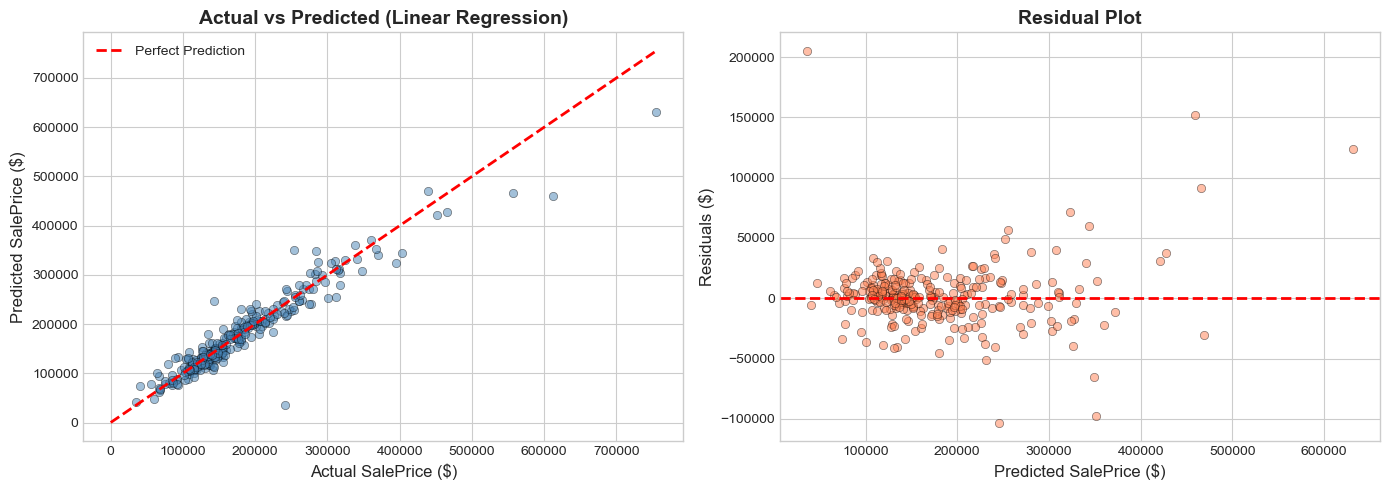

In [26]:
# Actual vs Predicted plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot - convert back from log scale for visualization
actual_prices = np.expm1(y_val)
predicted_prices = np.expm1(lr_val_pred)

axes[0].scatter(actual_prices, predicted_prices, alpha=0.5, c='steelblue', edgecolors='black', linewidth=0.5)
max_val = max(actual_prices.max(), predicted_prices.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual SalePrice ($)', fontsize=12)
axes[0].set_ylabel('Predicted SalePrice ($)', fontsize=12)
axes[0].set_title('Actual vs Predicted (Linear Regression)', fontsize=14, fontweight='bold')
axes[0].legend()

# Residual plot
residuals = actual_prices - predicted_prices
axes[1].scatter(predicted_prices, residuals, alpha=0.5, c='coral', edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted SalePrice ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

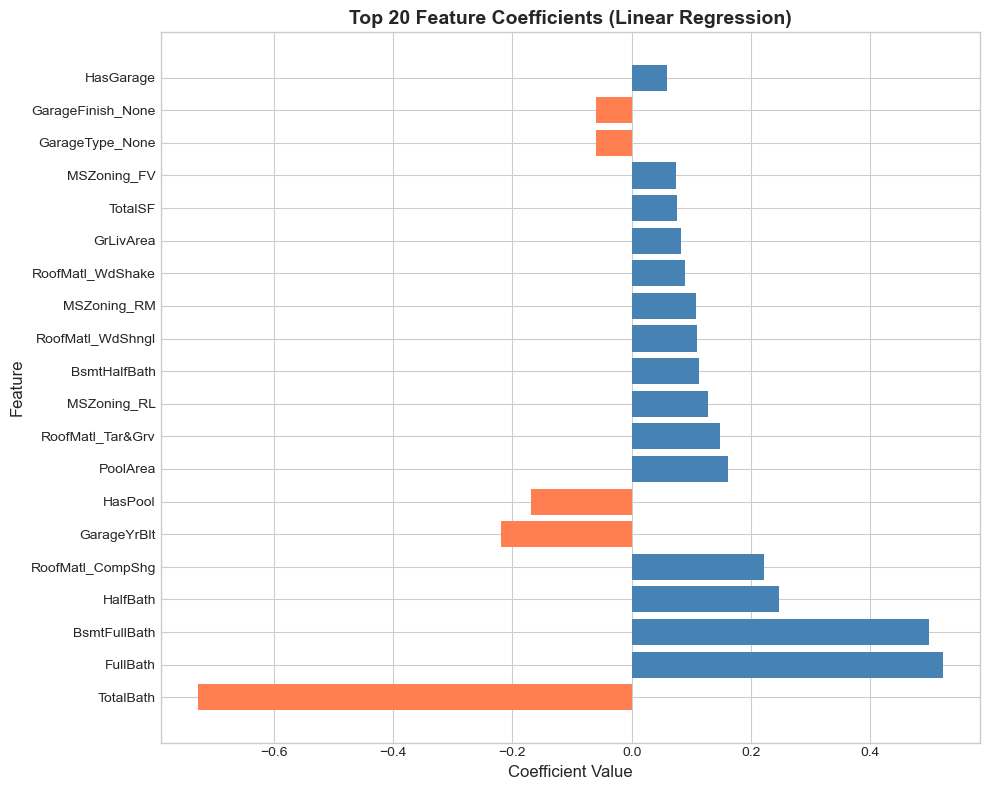

In [27]:
# Feature Importance (Top 20 coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False).head(20)

plt.figure(figsize=(10, 8))
colors = ['coral' if x < 0 else 'steelblue' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Coefficients (Linear Regression)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Model for Deployment

In [28]:
# Train final model on full training data
print("\n🔄 Training final model on full dataset...")

final_scaler = StandardScaler()
X_full_scaled = final_scaler.fit_transform(X)

final_model = LinearRegression()
final_model.fit(X_full_scaled, y)

print("✅ Final model trained!")


🔄 Training final model on full dataset...
✅ Final model trained!


In [29]:
# Save model and scaler to pickle files
print("\n💾 Saving model and scaler...")

# Save the model
with open('models/linear_regression_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save the scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(final_scaler, f)

# Save the feature names (important for prediction)
with open('models/feature_names.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)

print("✅ Model saved to: models/linear_regression_model.pkl")
print("✅ Scaler saved to: models/scaler.pkl")
print("✅ Feature names saved to: models/feature_names.pkl")


💾 Saving model and scaler...
✅ Model saved to: models/linear_regression_model.pkl
✅ Scaler saved to: models/scaler.pkl
✅ Feature names saved to: models/feature_names.pkl


In [30]:
# Test loading the saved model
print("\n🧪 Testing saved model...")

with open('models/linear_regression_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('models/scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Test prediction
sample = X.iloc[[0]]
sample_scaled = loaded_scaler.transform(sample)
sample_pred = loaded_model.predict(sample_scaled)
sample_price = np.expm1(sample_pred)[0]

print(f"   Sample prediction: ${sample_price:,.2f}")
print(f"   Actual price: ${y_train.iloc[0]:,.2f}")
print("\n✅ Model loading test successful!")


🧪 Testing saved model...
   Sample prediction: $208,505.30
   Actual price: $208,500.00

✅ Model loading test successful!


## 9. Predictions & Submission

In [31]:
# Generate predictions for test data
X_test_scaled = final_scaler.transform(X_test_final)
test_predictions_log = final_model.predict(X_test_scaled)
test_predictions = np.expm1(test_predictions_log)  # Convert back from log scale

print(f"\n📊 Test Predictions Summary:")
print(f"   Min: ${test_predictions.min():,.0f}")
print(f"   Max: ${test_predictions.max():,.0f}")
print(f"   Mean: ${test_predictions.mean():,.0f}")
print(f"   Median: ${np.median(test_predictions):,.0f}")


📊 Test Predictions Summary:
   Min: $36,991
   Max: $629,518
   Mean: $178,450
   Median: $157,914


In [32]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("\n✅ Submission file created: submission.csv")
print(f"\n📄 Preview of submission:")
submission.head(10)


✅ Submission file created: submission.csv

📄 Preview of submission:


,Id,SalePrice
0,1461,122205.090820
1,1462,168653.891871
2,1463,186836.156047
3,1464,199865.822216
4,1465,203054.813442
5,1466,170034.125011
6,1467,173574.282733
7,1468,159449.876859
8,1469,199657.049812
9,1470,118128.226543


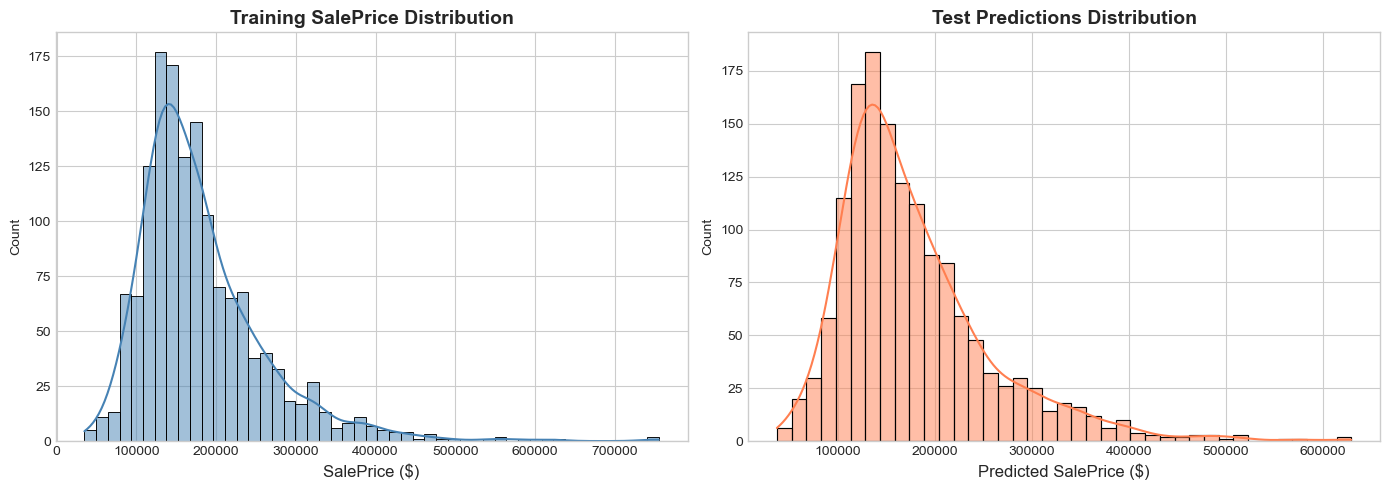

In [33]:
# Visualize predictions distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training data distribution
sns.histplot(y_train, kde=True, ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Training SalePrice Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('SalePrice ($)', fontsize=12)

# Test predictions distribution
sns.histplot(test_predictions, kde=True, ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('Test Predictions Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted SalePrice ($)', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/predictions_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Conclusion

In [34]:
print("\n" + "="*70)
print("                    🏆 PROJECT SUMMARY 🏆")
print("="*70)

print("\n📊 Dataset Statistics:")
print(f"   • Training samples: {ntrain:,}")
print(f"   • Test samples: {len(test_ids):,}")
print(f"   • Original features: 79")
print(f"   • Engineered features: {X.shape[1]}")

print("\n🤖 Model: Linear Regression")
print(f"   • Validation RMSE: {lr_val_rmse:.4f}")
print(f"   • R² Score: {lr_r2:.4f}")
print(f"   • Cross-Validation RMSE: {-cv_scores.mean():.4f}")

print("\n📈 Key Insights:")
print("   • Overall Quality is the most important predictor")
print("   • Living area (GrLivArea) strongly correlates with price")
print("   • Newer homes command higher prices")
print("   • Neighborhood significantly impacts property values")

print("\n📁 Generated Files:")
print("   • models/linear_regression_model.pkl - Trained model")
print("   • models/scaler.pkl - Feature scaler")
print("   • models/feature_names.pkl - Feature names")
print("   • submission.csv - Kaggle submission file")
print("   • visualizations/ - All generated plots")

print("\n" + "="*70)
print("         ✅ Project completed successfully!")
print("="*70)


                    🏆 PROJECT SUMMARY 🏆

📊 Dataset Statistics:
   • Training samples: 1,460
   • Test samples: 1,459
   • Original features: 79
   • Engineered features: 238

🤖 Model: Linear Regression
   • Validation RMSE: 0.1633
   • R² Score: 0.8571
   • Cross-Validation RMSE: 0.1553

📈 Key Insights:
   • Overall Quality is the most important predictor
   • Living area (GrLivArea) strongly correlates with price
   • Newer homes command higher prices
   • Neighborhood significantly impacts property values

📁 Generated Files:
   • models/linear_regression_model.pkl - Trained model
   • models/scaler.pkl - Feature scaler
   • models/feature_names.pkl - Feature names
   • submission.csv - Kaggle submission file
   • visualizations/ - All generated plots

         ✅ Project completed successfully!
